### Probablistic LSTM Modal

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader


In [187]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [308]:
# data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

filename = "EURUSD_M1_2023.csv"


df1 = pd.read_csv("./data_saved/EURUSD_M1_2021.csv")
df2 = pd.read_csv("./data_saved/EURUSD_M1_2022.csv")

concatenated_df = pd.concat([df1, df2], axis=0)
concatenated_df.reset_index(drop=True, inplace=True)


# df2 = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
concatenated_df['timestamp'] = pd.to_datetime(concatenated_df['timestamp']) 

#timestamp as index
concatenated_df.set_index('timestamp', inplace=True)
data = concatenated_df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

#Drop NA rows
data = data.dropna(axis=0)
data.reset_index(drop=True, inplace=True)


# data = data['close']


print(data.head(10))
print(data.describe())

# data = data.iloc[:100]


# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()


data

            timestamp     open     high      low    close
0 2021-01-03 17:00:00  1.22387  1.22420  1.22296  1.22315
1 2021-01-03 17:15:00  1.22324  1.22387  1.22324  1.22361
2 2021-01-03 17:30:00  1.22367  1.22400  1.22325  1.22339
3 2021-01-03 17:45:00  1.22340  1.22348  1.22325  1.22325
4 2021-01-03 18:00:00  1.22331  1.22412  1.22304  1.22369
5 2021-01-03 18:15:00  1.22392  1.22406  1.22336  1.22383
6 2021-01-03 18:30:00  1.22397  1.22481  1.22394  1.22458
7 2021-01-03 18:45:00  1.22470  1.22527  1.22435  1.22486
8 2021-01-03 19:00:00  1.22499  1.22499  1.22426  1.22449
9 2021-01-03 19:15:00  1.22454  1.22474  1.22406  1.22445
                           timestamp          open          high  \
count                          49831  49831.000000  49831.000000   
mean   2022-01-02 01:36:32.665208576      1.117939      1.118306   
min              2021-01-03 17:00:00      0.953900      0.955170   
25%              2021-07-05 08:37:30      1.052315      1.052730   
50%              2022-

,timestamp,open,high,low,close
0,2021-01-03 17:00:00,1.22387,1.22420,1.22296,1.22315
1,2021-01-03 17:15:00,1.22324,1.22387,1.22324,1.22361
2,2021-01-03 17:30:00,1.22367,1.22400,1.22325,1.22339
3,2021-01-03 17:45:00,1.22340,1.22348,1.22325,1.22325
4,2021-01-03 18:00:00,1.22331,1.22412,1.22304,1.22369
...,...,...,...,...,...
49826,2022-12-30 15:45:00,1.07021,1.07082,1.07016,1.07030
49827,2022-12-30 16:00:00,1.07057,1.07071,1.07021,1.07028
49828,2022-12-30 16:15:00,1.07033,1.07046,1.07001,1.07034
49829,2022-12-30 16:30:00,1.07040,1.07042,1.07010,1.07019


In [309]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# data_tensor = data_tensor[:100]

In [190]:
# # Define the Gaussian LSTM model
# class GaussianLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(GaussianLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc_mean = nn.Linear(hidden_size, output_size)  # Output mean
#         self.fc_variance = nn.Linear(hidden_size, output_size)  # Output variance

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         mean = self.fc_mean(out[:, -1, :])  # Mean of the Gaussian distribution
#         variance = torch.exp(self.fc_variance(out[:, -1, :]))  # Variance (apply exp to ensure positivity)
#         return mean, variance


In [191]:
# # class DeterministicLSTM(nn.Module):
# #     def __init__(self, input_size, hidden_size):
# #         super(DeterministicLSTM, self).__init__()
# #         self.hidden_size = hidden_size
# #         self.lstm = nn.LSTM(input_size, hidden_size)
# #         self.fc = nn.Linear(hidden_size, 1)  # Output a single point prediction

# #     def forward(self, input):
# #         lstm_out, _ = self.lstm(input)
# #         output = self.fc(lstm_out[-1])  # Use only the last output of the sequence
# #         return output


# import torch.nn.functional as F

# class DeterministicLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(DeterministicLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, 1)  # Output a single point prediction

#     def forward(self, input):
#         lstm_out, _ = self.lstm(input)
#         output = self.fc(lstm_out[-1])  # Use only the last output of the sequence
#         # output = F.relu(output)  # Applying ReLU activation function
#         return output

In [192]:

# # Train the model
# def train_model(model, criterion, optimizer, data_sequences_tensor, target_labels, num_epochs=100):
#     losses = []
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
#         mean, variance = model(data_sequences_tensor)
#         loss = criterion(target_labels, mean, variance)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#         if (epoch+1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     return losses

# # Define negative log likelihood loss for Gaussian distribution
# def gaussian_nll_loss(y_true, mean, variance):
#     return torch.mean(0.5 * torch.log(variance) + 0.5 * ((y_true - mean) ** 2) / variance)

# # Make predictions and calculate upper and lower bounds
# def predict(model, data_sequences_tensor):
#     mean, variance = model(data_sequences_tensor)
#     std_dev = torch.sqrt(variance)
#     upper_bound = mean + 2 * std_dev  # 95% confidence interval
#     lower_bound = mean - 2 * std_dev  # 95% confidence interval
#     return mean, upper_bound, lower_bound



# # Parameters
# input_size = 1
# hidden_size = 10
# num_layers = 2
# output_size = 1
# sequence_length = 15
# num_epochs = 10
# learning_rate = 0.001

# # Instantiate the model and move to GPU
# model = GaussianLSTM(input_size, hidden_size, num_layers, output_size)

# # Move the model to the same device as the input data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Prepare data with sequence length
# data_sequences_tensor = torch.cat([data_tensor[:, i:i+sequence_length, :] for i in range(len(data) - sequence_length)], dim=0)

# # Convert data sequences to PyTorch tensors and move to GPU
# data_sequences_tensor = data_sequences_tensor.to(device)

# # Target labels (using next data point as label for simplicity)
# target_labels = data_tensor[:, sequence_length:, :][:, -1, :].to(device)

# # Train the model
# losses = train_model(model, gaussian_nll_loss, optimizer, data_sequences_tensor, target_labels, num_epochs)

In [193]:
# # Define the window size
# window_size = 10

# # Generate X_train and y_train tensors
# X_train = torch.cat([data_tensor[:, i:i+window_size] for i in range(len(data_tensor[0]) - window_size)], dim=0)
# y_train = data_tensor[:, window_size:].squeeze(0)  # Remove the extra dimension

# # Convert y_train to have an extra dimension for single output
# y_train = y_train.unsqueeze(2)

# # Print shapes for verification
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)

# # Model parameters
# input_size = 1  # Assuming univariate time series
# hidden_size = 32
# learning_rate = 0.001
# num_epochs = 500

# # Create model instance
# model = DeterministicLSTM(input_size, hidden_size)

# # Move the model to the same device as the input data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# losses = []
# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     output = model(X_train)
#     loss = criterion(output, y_train)
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())
#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [194]:
# filename = "EURUSD_M1_202401.csv"


# pred_df = pd.read_csv("./data_saved/"+filename)
#  # Convert 'timestamp' column to datetime
# pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp']) 

# #timestamp as index
# pred_df.set_index('timestamp', inplace=True)
# pred_data = df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

# #Drop NA rows
# pred_data = pred_data.dropna(axis=0)

# # Convert DataFrame to PyTorch tensor and move to GPU
# pred_data_tensor = torch.tensor(pred_data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# # with torch.no_grad():
# # predicted_output = model(pred_data_tensor)

# # Make predictions
# with torch.no_grad():
#     model.eval()  # Set the model to evaluation mode
#     predicted_output = model(pred_data_tensor)

# print(predicted_output)

# test_loss = criterion(predicted_output, pred_data_tensor)

# print('Test Loss:', test_loss.item())


In [195]:
# # Plotting (optional)
# plt.plot(pred_data_tensor[0].cpu().numpy(), label='Actual Data', color='blue')  # Convert tensor to numpy array

# # Generate the range based on the length of the predicted data
# predicted_range = range(0, len(predicted_output))
# plt.plot(predicted_range, predicted_output.cpu().detach().numpy(), label='Predicted Data', color='red')

# plt.title('Deterministic LSTM Prediction')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [196]:
# # Plot loss function within epochs
# plt.plot(losses, label='Training Loss')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### Batch training 



In [202]:
# # Define the window size

# # Assuming you have defined data_tensor, window_size, and target_tensor previously

# # Define window size
# window_size = 1000

# # Generate X_train and y_train tensors
# X_train = torch.cat([data_tensor[:, i:i+window_size] for i in range(len(data_tensor[0]) - window_size)], dim=0)
# y_train = data_tensor[:, window_size:].squeeze(0)  # Remove the extra dimension

# # Convert y_train to have an extra dimension for single output
# y_train = y_train.unsqueeze(2)

# # Split data into training and validation sets
# split_ratio = 0.8  # 80% for training, 20% for validation
# split_index = int(len(X_train) * split_ratio)

# X_train_data, X_val_data = X_train[:split_index], X_train[split_index:]
# y_train_data, y_val_data = y_train[:split_index], y_train[split_index:]

# # Define batch size
# batch_size = 32  # You can adjust this value based on your memory constraints

# # Create DataLoader for training data
# train_dataset = TensorDataset(X_train_data, y_train_data)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Create DataLoader for validation data
# val_dataset = TensorDataset(X_val_data, y_val_data)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# # Model parameters
# input_size = 1  # Assuming univariate time series
# hidden_size = 32
# learning_rate = 0.01
# num_epochs = 10

# # Create model instance
# model = DeterministicLSTM(input_size, hidden_size)


# # Move the model to the same device as the input data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# train_losses = []
# val_losses = []
# for epoch in range(num_epochs):
#     # Training loop
#     model.train()
#     for batch_data, batch_target in train_loader:
#         batch_data = batch_data.to(device)
#         batch_target = batch_target.to(device)

#         optimizer.zero_grad()
#         output = model(batch_data)
#         output = F.relu(output)  # Applying ReLU activation function
#         loss = criterion(output, batch_target)
#         loss.backward()
#         optimizer.step()
#         train_losses.append(loss.item())
    
#     # Validation loop
#     model.eval()
#     with torch.no_grad():
#         val_loss = 0
#         for batch_data, batch_target in val_loader:
#             batch_data = batch_data.to(device)
#             batch_target = batch_target.to(device)

#             output = model(batch_data)
#             val_loss += criterion(output, batch_target).item()
#         val_losses.append(val_loss / len(val_loader))
    
#     if (epoch+1) % 1 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([25, 1, 1])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1, 1])) that is different to the input size (torch.Size([1000, 1])). This will

Epoch [1/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [2/10], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [3/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [4/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [5/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [6/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [7/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [8/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [9/10], Train Loss: 0.0004, Val Loss: 0.0003
Epoch [10/10], Train Loss: 0.0004, Val Loss: 0.0002


In [306]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [310]:
# Create a new dataframe with only the 'Close' column
data = data.filter(['close'])

data

,close
0,1.22315
1,1.22361
2,1.22339
3,1.22325
4,1.22369
...,...
49826,1.07030
49827,1.07028
49828,1.07034
49829,1.07019


### Training the modal

In [311]:
# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data
print("Scalling data")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Convert the training data to PyTorch tensors and move to GPU
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

# Define the LSTM model and move to GPU
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                            torch.zeros(1,1,self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

print("Initializing Modal")
# Initialize the model, loss function, and optimizer
model = LSTMModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training Modal")
# Train the model on GPU
epochs = 5  # Adjust number of epochs as needed
train_losses = []
for i in range(epochs):
    for seq, labels in zip(x_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        train_losses.append(single_loss.item())
        optimizer.step()

    if (i+1) % 1 == 0:
        print(f'Epoch [{i+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}')



Scalling data
Initializing Modal
Training Modal


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/5], Train Loss: 0.0000
Epoch [2/5], Train Loss: 0.0000
Epoch [3/5], Train Loss: 0.0000
Epoch [4/5], Train Loss: 0.0000
Epoch [5/5], Train Loss: 0.0000


### testing the modal

In [312]:

# Create the testing data set
test_data = scaled_data[training_data_len-60:, :]
x_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = torch.from_numpy(np.array(x_test)).float().to(device)

# Make predictions on GPU
predictions = []
with torch.no_grad():
    for i in range(len(x_test)):
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        predictions.append(model(x_test[i]))

# Convert predictions back to numpy array and inverse scale
predictions = torch.tensor(predictions).view(-1).cpu().numpy()
predictions = predictions.reshape(-1,1)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
y_test = dataset[training_data_len:, :]
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

valid

Root Mean Squared Error (RMSE): 0.017483572364170308


C:\Users\ACER\AppData\Local\Temp\ipykernel_16624\2677219771.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,close,Predictions
47340,1.04064,1.040806
47341,1.04079,1.040807
47342,1.04074,1.040806
47343,1.03985,1.040806
47344,1.03985,1.040809
...,...,...
49826,1.07030,1.040737
49827,1.07028,1.040737
49828,1.07034,1.040737
49829,1.07019,1.040737


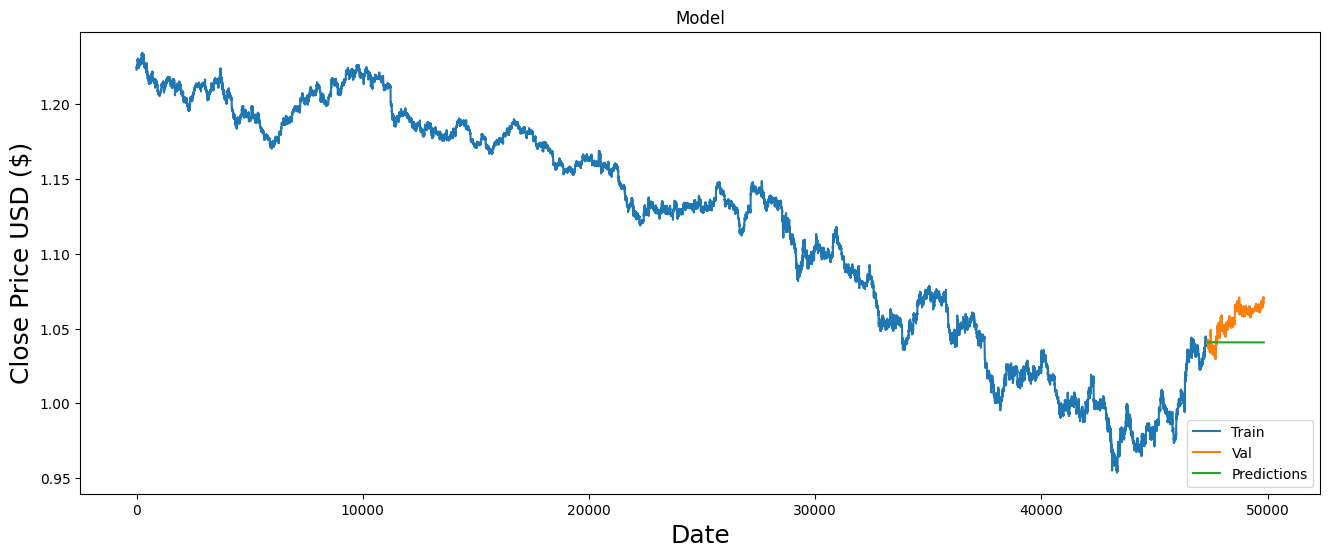

In [313]:

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [252]:
# Show the valid and predicted prices
valid

,close,Predictions
33226,1.08913,1.089061
33227,1.08924,1.089349
33228,1.08854,1.089311
33229,1.08867,1.088580
33230,1.08915,1.088606
...,...,...
34747,1.10391,1.093772
34748,1.10354,1.093525
34749,1.10349,1.093307
34750,1.10366,1.093331


### Use the modal to predict another dataset

In [260]:

filename = "EURUSD_M1_202401.csv"
sqe_len = 60


pred_df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp']) 

#timestamp as index
pred_df.set_index('timestamp', inplace=True)
pred_data = pred_df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

# Assuming df_test is your dataframe containing the new data for prediction
# Use the same scaler as used for training data
# Convert the dataframe to a numpy array
dataset_test = pred_data.filter(['close']).values

# Scale the data using the same scaler as used for training data
scaled_data_test = scaler.transform(dataset_test)


### predicting next price

In [261]:
# Create the input sequence for real-time prediction
pred_data_squ = scaled_data_test[-sqe_len:]  # Assuming you want to predict based on the last 60 data points


# Convert input sequence to PyTorch tensor and move to GPU
pred_data_squ = torch.from_numpy(pred_data_squ).float().to(device)

# Make predictions on GPU
# predictions = []
# with torch.no_grad():
#     for i in range(len(x_test)):
#         model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
#                         torch.zeros(1, 1, model.hidden_layer_size).to(device))
#         predictions.append(model(x_test[i]))

# Make predictions on GPU
predictions_real_time = []
with torch.no_grad():
    model.eval()
    model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                    torch.zeros(1, 1, model.hidden_layer_size).to(device))
    prediction = model(pred_data_squ)
    predictions_real_time.append(prediction.item())  # Assuming output size is 1

# Inverse scale the prediction
predicted_price = scaler.inverse_transform(np.array(predictions_real_time).reshape(-1, 1))

print("Predicted price:", predicted_price[0])
print("Loss:", dataset_test[sqe_len]  - predicted_price[0])


Predicted price: [1.08674932]
Loss: [0.00894068]


In [294]:
# Make predictions on GPU
num_of_pred = 10
predictions_real_time = []
with torch.no_grad():
    for i in range(num_of_pred):
        # print(-(sqe_len - i))
        # Create the input sequence for real-time prediction
        # Assuming you want to predict based on the last 60 data points
        pred_data_squs = scaled_data_test[i: 60 + i]
        # Convert input sequence to PyTorch tensor and move to GPU
        pred_data_squs_tensor = torch.from_numpy(pred_data_squs).float().to(device)

        # print(pred_data_squs)
        model.eval()
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        prediction = model(pred_data_squs_tensor)
        predictions_real_time.append(prediction.item())  # Assuming output size is 1

# Inverse scale the prediction
predicted_price = scaler.inverse_transform(np.array(predictions_real_time).reshape(-1, 1))

print("Predicted price:", predicted_price)
# print("Loss:", dataset_test[60]  - predicted_price[0])


Predicted price: [1.08916158]


#### predicting next 10 squence of prices

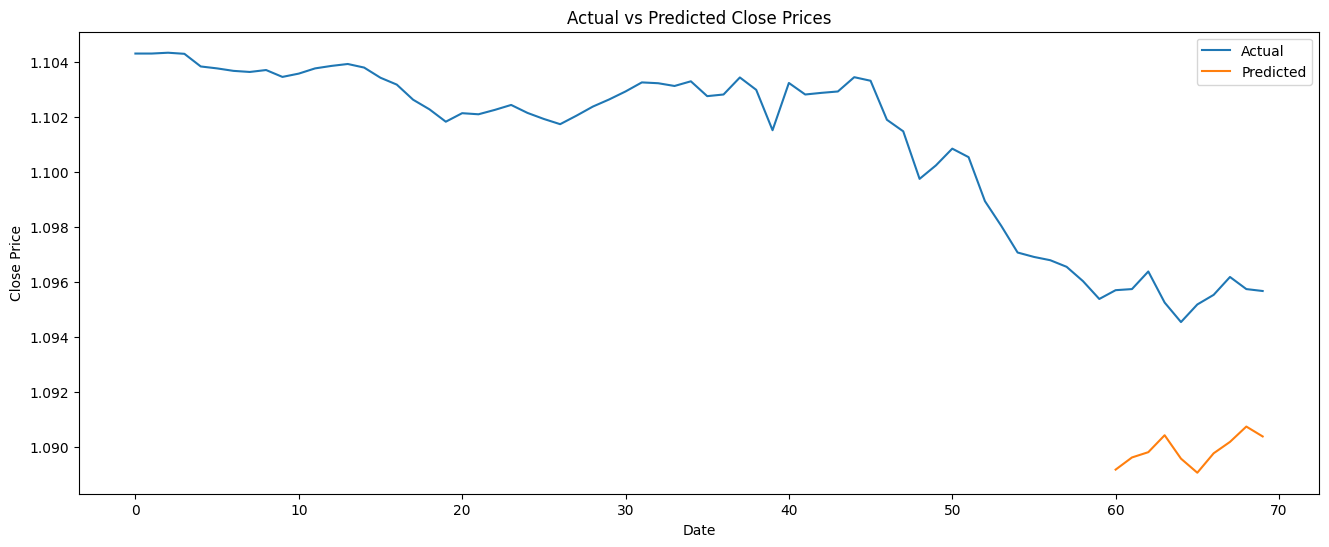

In [303]:
# Convert the predictions for the new data to a pandas DataFrame
predicted_df = pd.DataFrame(predicted_price, columns=['Predicted'])
# print(predicted_df)
actual_df = pd.DataFrame(dataset_test[0: 70], columns=['Actual'])
# print(actual_df)


predicted_df = pd.concat([actual_df[0: 60], predicted_df], axis=0)
predicted_df.reset_index(drop=True, inplace=True)

# Plot the actual and predicted data
plt.figure(figsize=(16,6))
plt.plot(actual_df.index, actual_df['Actual'], label='Actual')
plt.plot(predicted_df.index, predicted_df['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [210]:
filename = "EURUSD_M1_202401.csv"

pred_df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp']) 

#timestamp as index
pred_df.set_index('timestamp', inplace=True)
pred_data = pred_df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

#Drop NA rows
pred_data = pred_data.dropna(axis=0)

# Convert DataFrame to PyTorch tensor and move to GPU
pred_data_tensor = torch.tensor(pred_data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# with torch.no_grad():
# predicted_output = model(pred_data_tensor)

# Make predictions
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    predicted_output = model(pred_data_tensor)

print(predicted_output)

test_loss = criterion(predicted_output, pred_data_tensor)

print('Test Loss:', test_loss.item())
# Test Loss: 0.025905614718794823

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 1804

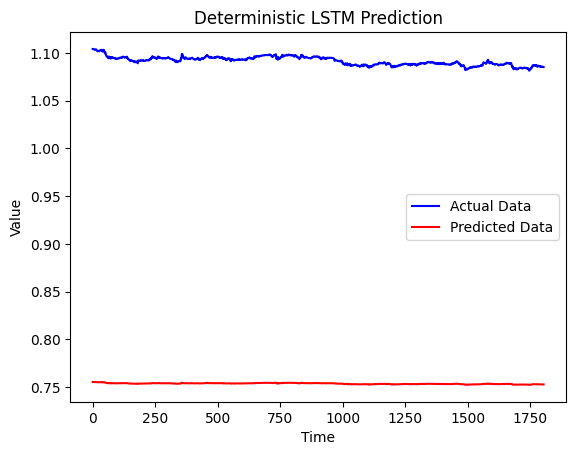

In [164]:
# Plotting (optional)
plt.plot(pred_data_tensor[0].cpu().numpy(), label='Actual Data', color='blue')  # Convert tensor to numpy array

# Generate the range based on the length of the predicted data
predicted_range = range(0, len(predicted_output))
plt.plot(predicted_range, predicted_output.cpu().detach().numpy(), label='Predicted Data', color='red')

plt.title('Deterministic LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [15]:
output.cpu().detach().numpy()

array([[0.9897065 ],
       [0.9897424 ],
       [0.9897374 ],
       [0.9897314 ],
       [0.9897561 ],
       [0.98979044],
       [0.9897717 ],
       [0.989702  ],
       [0.9897277 ],
       [0.98974186],
       [0.9896863 ],
       [0.9896356 ],
       [0.98962396],
       [0.9896022 ],
       [0.98962545],
       [0.9896796 ],
       [0.98966056],
       [0.9896306 ],
       [0.9895967 ],
       [0.98957276]], dtype=float32)

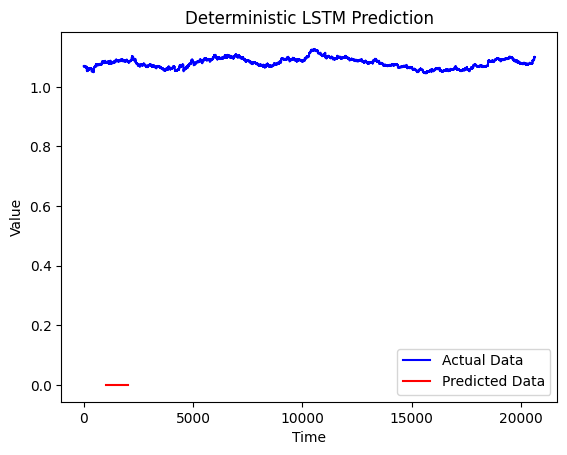

In [182]:
# Plotting (optional)
plt.plot(data_tensor[0].cpu().numpy()[:len(data_tensor[0]) - window_size], label='Actual Data', color='blue')  # Convert tensor to numpy array

# Generate the range based on the length of the predicted data
predicted_range = range(window_size, window_size + len(output))
plt.plot(predicted_range, output.cpu().detach().numpy(), label='Predicted Data', color='red')

plt.title('Deterministic LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

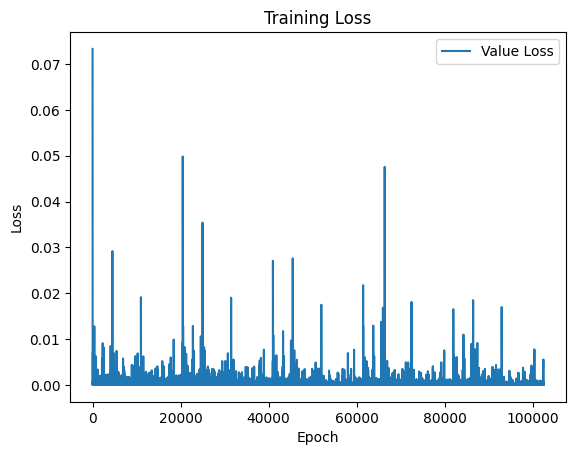

In [213]:
# Plot loss function within epochs
# plt.plot(train_losses, label='Training Loss')
plt.plot(train_losses, label='Value Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [212]:
#### save trained modal
torch.save(model.state_dict(), './TrainedModals/LSTM_15M_5epoch.pth')


In [160]:
# Make predictions
# mean_pred, upper_bound_pred, lower_bound_pred = predict(model, data_sequences_tensor)

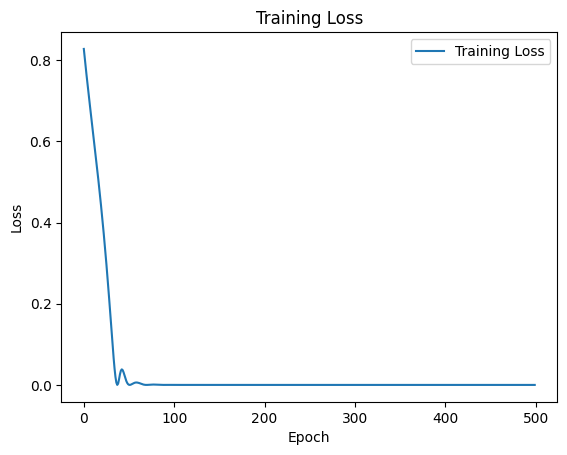

In [37]:
# Plot loss function within epochs
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
data

,timestamp,open,high,low,close
0,2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06970
1,2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966
2,2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06970
3,2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972
4,2023-01-01 17:11:00,1.06972,1.06972,1.06972,1.06972
...,...,...,...,...,...
322632,2023-12-29 16:54:00,1.10388,1.10390,1.10387,1.10387
322633,2023-12-29 16:55:00,1.10389,1.10395,1.10387,1.10387
322634,2023-12-29 16:56:00,1.10394,1.10394,1.10367,1.10367
322635,2023-12-29 16:57:00,1.10366,1.10366,1.10366,1.10366


In [48]:
# upper_bound_pred.squeeze().cpu().detach().numpy()

array([1.10829  , 1.10829  , 1.1082898, ..., 1.1082646, 1.1082647,
       1.1082647], dtype=float32)

In [49]:
# lower_bound_pred

tensor([[1.1014],
        [1.1014],
        [1.1014],
        ...,
        [1.1014],
        [1.1014],
        [1.1014]], device='cuda:0', grad_fn=<SubBackward0>)

In [50]:
# data.close

0         1.06970
1         1.06966
2         1.06970
3         1.06972
4         1.06972
           ...   
322632    1.10387
322633    1.10387
322634    1.10367
322635    1.10366
322636    1.10361
Name: close, Length: 322637, dtype: float64

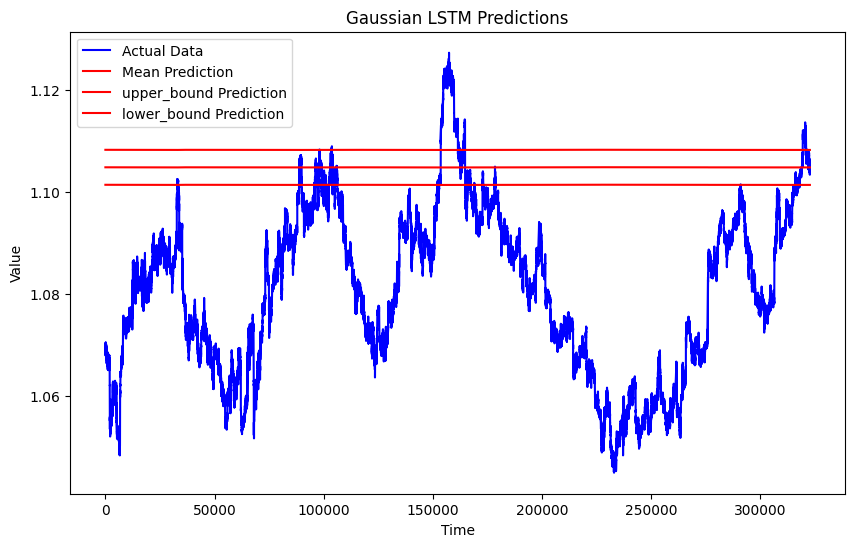

In [51]:
# Plot predictions
def plot_predictions(data, mean, upper_bound, lower_bound):
    # data = data.flatten()
    plt.figure(figsize=(10, 6))
    plt.plot(data['close'], label='Actual Data', color='blue')
    plt.plot(mean, label='Mean Prediction', color='red')
    plt.plot(upper_bound, label='upper_bound Prediction', color='red')
    plt.plot(lower_bound, label='lower_bound Prediction', color='red')
    # plt.fill_between(range(len(mean)), upper_bound, lower_bound, color='orange', alpha=0.3, label='95% Confidence Interval')
    plt.title('Gaussian LSTM Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot predictions
plot_predictions(data, mean_pred.squeeze().cpu().detach().numpy(), 
                  upper_bound_pred.squeeze().cpu().detach().numpy(), 
                  lower_bound_pred.squeeze().cpu().detach().numpy())

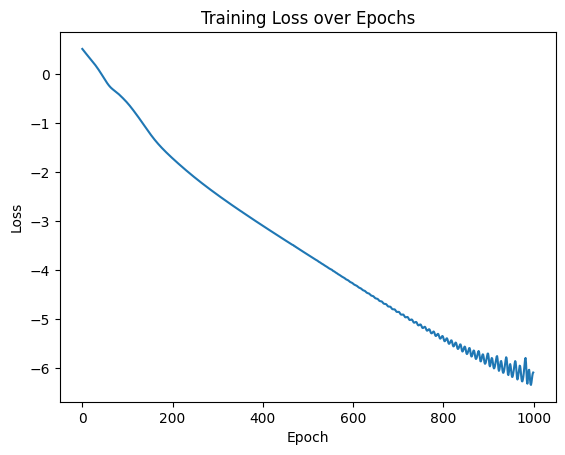

In [52]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Save PyTorch model
# torch.save(model.state_dict(), './TrainedModals/lstm_probablistic_2023.pth')


In [53]:
# import matplotlib.pyplot as plt

# # Select a subset of 1000 timestamps
# subset_df = predictions_df.iloc[0:100]

# # Plot close price
# plt.figure(figsize=(12, 6))
# plt.plot(subset_df['Timestamp'], data['close'][0:100], label='Close Price', color='black')

# # Add dots to show predictions
# for index, row in subset_df.iterrows():
#     if row['Probability (Up)'] > 0.5:  # Upward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='green', label='Predicted Up', zorder=1)
#     else:  # Downward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='red', label='Predicted Down', zorder=1)

# plt.title('Close Price and Predicted Movements')
# plt.xlabel('Timestamp (Hourly)')
# plt.ylabel('Close Price')
# plt.xticks(subset_df['Timestamp'][::100], rotation=45, ha='right')  # Show every 10th timestamp for better readability
# plt.tight_layout()
# plt.show()


NameError: name 'predictions_df' is not defined